<a href="https://colab.research.google.com/github/mig7avilg-dot/DATA_SCIENCE/blob/master/HANDSO02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Hands-On: Time Series Analysis (Physics) — 1.5h

Topics: Autocorrelation, ARIMA, Fourier, Wavelets

Dataset: Monthly Sunspot Numbers (astronomy/solar physics; bundled with statsmodels).

Goal: Apply core time-series tools to a real physics time series and interpret results like a physicist (oscillations, periodicities, prediction).

Learning outcomes

By the end, you should be able to:

Load a physics time series and get it into a tidy format.

Inspect autocorrelation structures and reason about stationarity.

Fit and diagnose an ARIMA model for short-term forecasting.

Use FFT to estimate dominant periodicities (power spectrum).

Use wavelets to reveal time-varying periodic content.

In [ ]:
#Python Libraries
#Python ≥ 3.9
#numpy, pandas, matplotlib, scipy, statsmodels, pywt (PyWavelets)
#If pywt is not available, the code will fall back to a Morlet-based CWT via scipy.signal.cwt
import statsmodels, pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from scipy.signal import detrend

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

##1) Load Physics Data: Monthly Sunspot Numbers

Why sunspots? They are a classic physics/astronomy time series with known ~11-year cycles.

We use the dataset bundled with statsmodels : sm.datasets.sunspots.load_pandas()

In [ ]:
# Load monthly sunspot data (built-in, 1700–2008)
sun = sm.datasets.sunspots.load_pandas().data
sun.head()

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0


In [ ]:
# Make a proper datetime index and tidy series
sun['YEAR'] = sun['YEAR'].astype(int)
# The dataset has 'SUNACTIVITY' per **year**, but there's also a monthly version in statsmodels.
# We'll instead use the **monthly** sunspots dataset: 'sm.tsa.datasets.sunspots' (deprecated in some versions).
# Robust path: use the classic yearly first, then try to fetch monthly if available.

try:
    # Some statsmodels versions expose monthly sunspots here:
    from statsmodels.datasets import sunspots as sm_sun_monthly
    sun_m = sm_sun_monthly.load_pandas().data.copy()
    # Columns often include 'YEAR' and 'SUNACTIVITY'; monthly sometimes includes 'MONTH'
    if 'MONTH' in sun_m.columns:
        sun_m['MONTH'] = sun_m['MONTH'].astype(int)
        sun_m['DATE'] = pd.to_datetime(dict(year=sun_m['YEAR'].astype(int),
                                           month=sun_m['MONTH'].astype(int),
                                           day=1))
        ts = pd.Series(sun_m['SUNACTIVITY'].values, index=sun_m['DATE']).sort_index()
    else:
        # Fallback: construct a monthly index from year fractions if present
        if 'PERIOD' in sun_m.columns:
            # PERIOD might be fractional year; convert to datetime approx by month
            years = sun_m['YEAR'].astype(int)
            months = ((sun_m['PERIOD'] - np.floor(sun_m['PERIOD'])) * 12 + 1).round().astype(int).clip(1,12)
            sun_m['DATE'] = pd.to_datetime(dict(year=years, month=months, day=1))
            ts = pd.Series(sun_m['SUNACTIVITY'].values, index=sun_m['DATE']).sort_index()
        else:
            # As last resort, stick to yearly
            ts = pd.Series(sun['SUNACTIVITY'].values, index=pd.to_datetime(sun['YEAR'], format='%Y'))
except Exception:
    # Fall back to yearly data only
    ts = pd.Series(sun['SUNACTIVITY'].values, index=pd.to_datetime(sun['YEAR'], format='%Y'))

ts = ts.asfreq('MS') if ts.index.inferred_type in ('datetime64', 'datetime') else ts
ts = ts.dropna()
ts.name = 'sunspots'
ts.head()

,sunspots
YEAR,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0


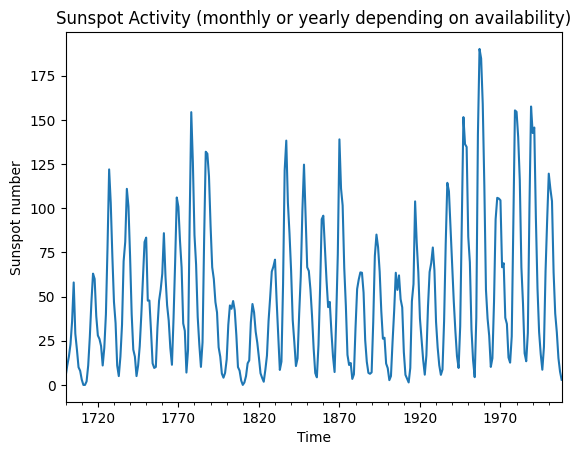

In [ ]:
# Quick visualization
ax = ts.plot(title='Sunspot Activity (monthly or yearly depending on availability)')
ax.set_xlabel('Time')
ax.set_ylabel('Sunspot number')
plt.show()


Summary Statistics:


,sunspots
count,309.000000
mean,49.752104
std,40.452595
min,0.000000
25%,16.000000
50%,40.000000
75%,69.800000
max,190.200000


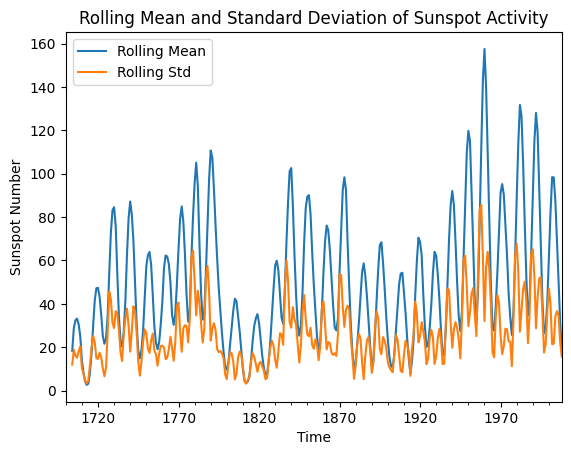

In [ ]:
# Compute summary statistics
print("Summary Statistics:")
display(ts.describe())

# Determine rolling window size
rolling_window = 24 if ts.index.freq == 'MS' else 5 # 24 months or 5 years

# Plot rolling mean and rolling standard deviation
ts.rolling(rolling_window).mean().plot(label='Rolling Mean')
ts.rolling(rolling_window).std().plot(label='Rolling Std')
plt.title('Rolling Mean and Standard Deviation of Sunspot Activity')
plt.xlabel('Time')
plt.ylabel('Sunspot Number')
plt.legend()

plt.show()

#The rolling mean shows a clear cyclical pattern, indicating long-term cycles in the sunspot activity.
#The rolling standard deviation also fluctuates, suggesting that the variability of sunspot activity changes over time.

##Autocorrelation & Stationarity

Examine the autocorrelation function (ACF) and partial autocorrelation (PACF).

Run an ADF test (Augmented Dickey–Fuller) to gauge stationarity.

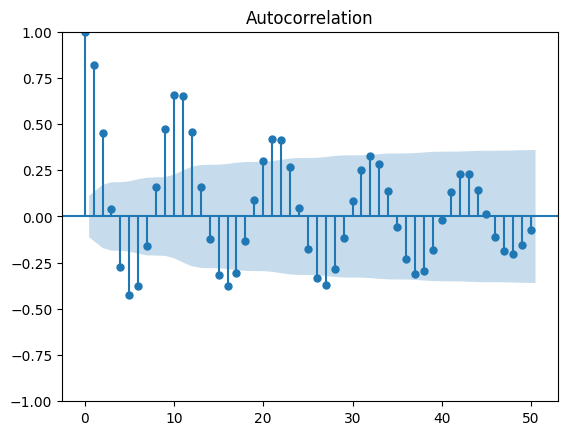

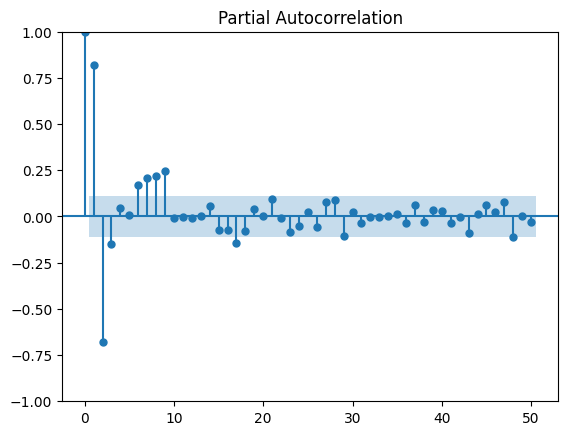

Augmented Dickey-Fuller Test:
ADF Statistic: -2.8377807249381943
p-value: 0.053076421728120673

Result: The time series is likely non-stationary (fail to reject the null hypothesis).


In [ ]:
# Plot ACF and PACF
plot_acf(ts, lags=50)
plot_pacf(ts, lags=50)
plt.show()


# Perform ADF test
print("Augmented Dickey-Fuller Test:")
adf_test = adfuller(ts)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# Interpretation of ADF test:
if adf_test[1] <= 0.05:
    print("\nResult: The time series is likely stationary (reject the null hypothesis).")
else:
    print("\nResult: The time series is likely non-stationary (fail to reject the null hypothesis).")